In [1]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf # To download historical stock data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import datetime

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# --- 2. Configuration ---
STOCK_TICKER = 'RELIANCE.NS' # Reliance
START_DATE = '2015-01-01'
END_DATE = datetime.datetime.now().strftime('%Y-%m-%d') # Current date
PREDICTION_DAYS = 60 # Number of past days to use for prediction
FUTURE_PRED_DAYS = 30 # Number of days to predict into the future (for LSTM)

print(f"--- Stock Price Prediction Project for {STOCK_TICKER} ---")
print(f"Data from {START_DATE} to {END_DATE}\n")

--- Stock Price Prediction Project for RELIANCE.NS ---
Data from 2015-01-01 to 2025-08-04



In [3]:
# --- 3. Data Acquisition ---
print("--- 3. Data Acquisition ---")
try:
    df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
    if df.empty:
        raise ValueError("No data downloaded. Check ticker or date range.")
    print(f"Successfully downloaded {len(df)} rows of data.\n")
    print("Initial Data Head:")
    print(df.head())
    print("\nData Info:")
    df.info()
    print("\n")
except Exception as e:
    print(f"Error downloading data: {e}")
    exit()

--- 3. Data Acquisition ---


[*********************100%***********************]  1 of 1 completed

Successfully downloaded 2614 rows of data.

Initial Data Head:
Price            Close        High         Low        Open      Volume
Ticker     RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS
Date                                                                  
2015-01-01  190.758636  191.639494  189.845553  190.414898     2963643
2015-01-02  190.253769  192.509623  189.985223  190.801616     7331366
2015-01-05  188.169769  191.403157  187.793791  190.135579    10103941
2015-01-06  179.629791  187.557482  178.748934  186.912959    18627980
2015-01-07  183.539932  184.506725  179.823163  179.844647    20720312

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2614 entries, 2015-01-01 to 2025-08-01
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Close, RELIANCE.NS)   2614 non-null   float64
 1   (High, RELIANCE.NS)    2614 non-null   float64
 2   (Low, RELIANCE.NS)  

In [4]:
# --- 4. Data Preprocessing & Feature Engineering ---
print("--- 4. Data Preprocessing & Feature Engineering ---")

# Keep only the 'Close' price for simplicity for initial models,
# but we'll use more features for LSTM.
data = df[['Close']].copy()

# Feature Engineering: Create Lagged Features
# Predict 'Close' price based on previous day's 'Close' price
data['Prev_Close'] = data['Close'].shift(1)
# You can add more lagged features, e.g., 'Prev_Volume', 'Prev_High', etc.

# Create Moving Averages as features
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_30'] = data['Close'].rolling(window=30).mean()

# Drop rows with NaN values created by shifting and rolling means
data.dropna(inplace=True)
print(f"\nData after feature engineering and NaN removal ({len(data)} rows):")
print(data.head())
print("\n")

# Target Variable (y) and Features (X)
# For Linear Regression, we'll use 'Prev_Close', 'SMA_10', 'SMA_30' to predict 'Close'
X_lr = data[['Prev_Close', 'SMA_10', 'SMA_30']]
y_lr = data['Close']

# Splitting Data for Linear Regression (Chronological Split)
# Use 80% for training, 20% for testing
train_size_lr = int(len(X_lr) * 0.8)
X_train_lr, X_test_lr = X_lr[:train_size_lr], X_lr[train_size_lr:]
y_train_lr, y_test_lr = y_lr[:train_size_lr], y_lr[train_size_lr:]

print(f"Linear Regression Training data size: {len(X_train_lr)}")
print(f"Linear Regression Testing data size: {len(X_test_lr)}\n")

--- 4. Data Preprocessing & Feature Engineering ---

Data after feature engineering and NaN removal (2585 rows):
Price            Close  Prev_Close      SMA_10      SMA_30
Ticker     RELIANCE.NS                                    
Date                                                      
2015-02-12  195.324036  193.508652  195.761267  190.505498
2015-02-13  197.117996  195.324036  195.809605  190.717477
2015-02-16  193.959808  197.117996  195.696814  190.841012
2015-02-18  193.712738  193.959808  194.924452  191.025777
2015-02-19  193.798691  193.712738  194.349748  191.498074


Linear Regression Training data size: 2068
Linear Regression Testing data size: 517



--- 5. Exploratory Data Analysis (EDA) & Visualization ---


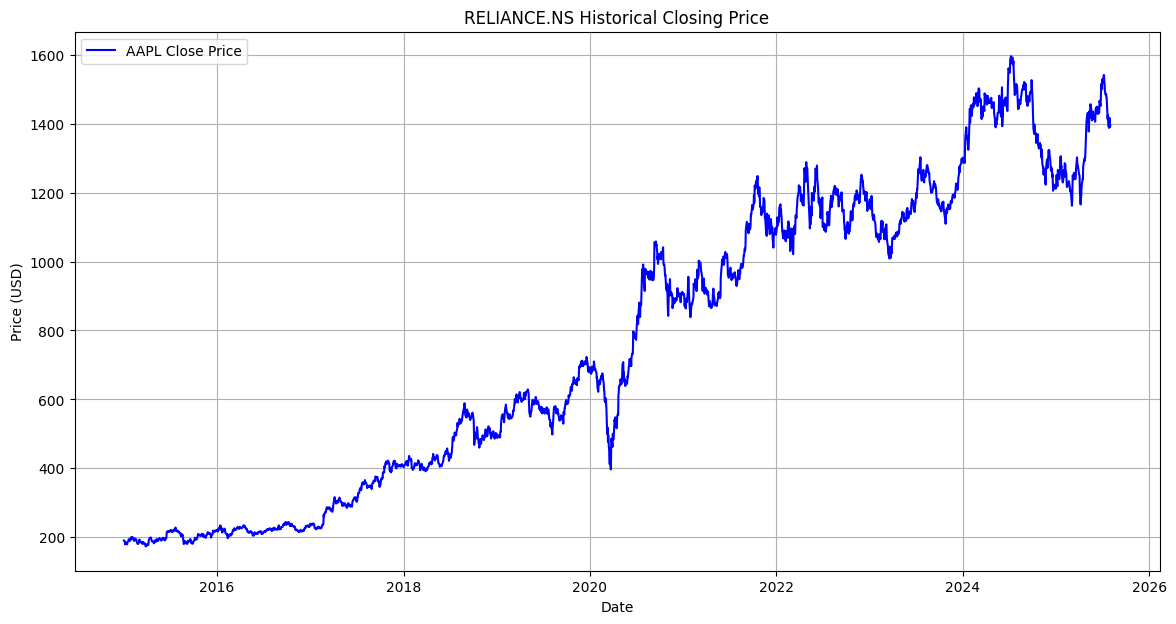

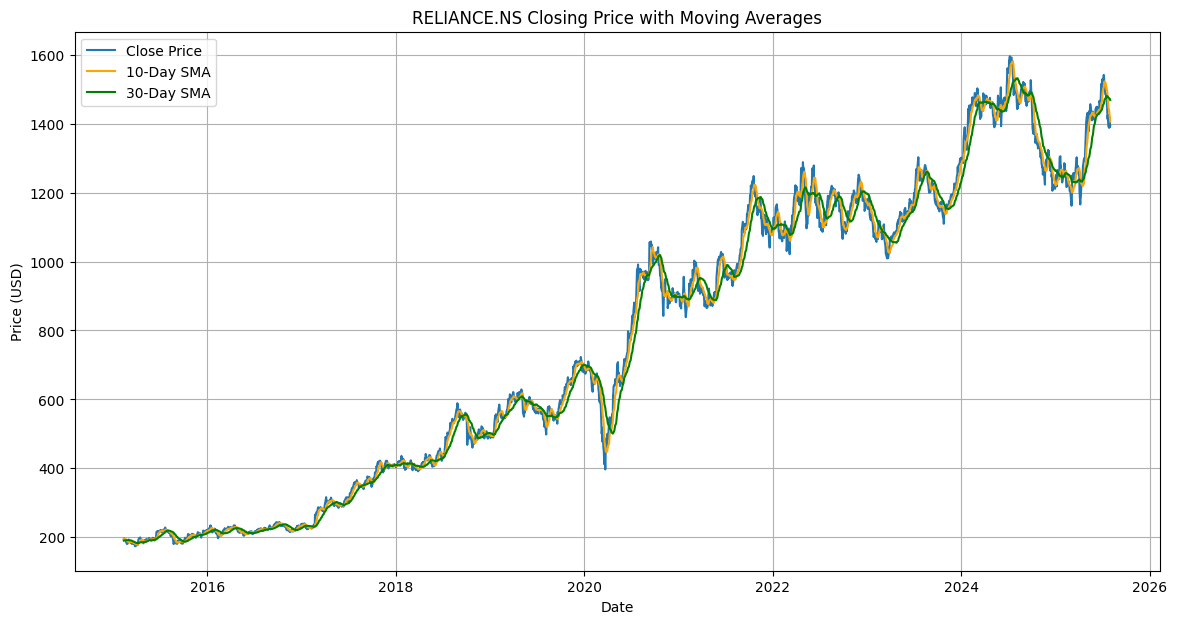

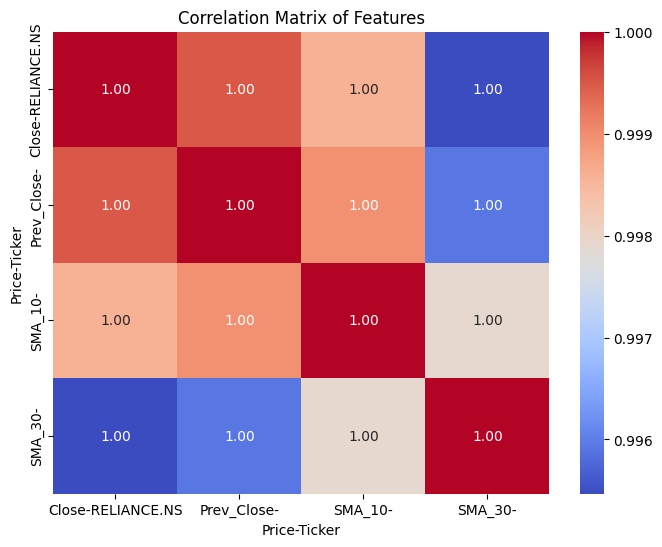

In [5]:
# --- 5. Exploratory Data Analysis (EDA) & Visualization ---
print("--- 5. Exploratory Data Analysis (EDA) & Visualization ---")

plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='AAPL Close Price', color='blue')
plt.title(f'{STOCK_TICKER} Historical Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_10'], label='10-Day SMA', color='orange')
plt.plot(data['SMA_30'], label='30-Day SMA', color='green')
plt.title(f'{STOCK_TICKER} Closing Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()
print("\n")

In [6]:
# --- 6. Model Building and Training (Linear Regression) ---
print("--- 6. Model Building and Training (Linear Regression) ---")

linear_model = LinearRegression()
linear_model.fit(X_train_lr, y_train_lr)

# Make predictions on the test set
lr_predictions = linear_model.predict(X_test_lr)

--- 6. Model Building and Training (Linear Regression) ---


--- 7. Model Evaluation (Linear Regression) ---
Linear Regression Metrics:
  Mean Squared Error (MSE): 328.40
  Root Mean Squared Error (RMSE): 18.12
  Mean Absolute Error (MAE): 13.09
  R-squared (R²): 0.98



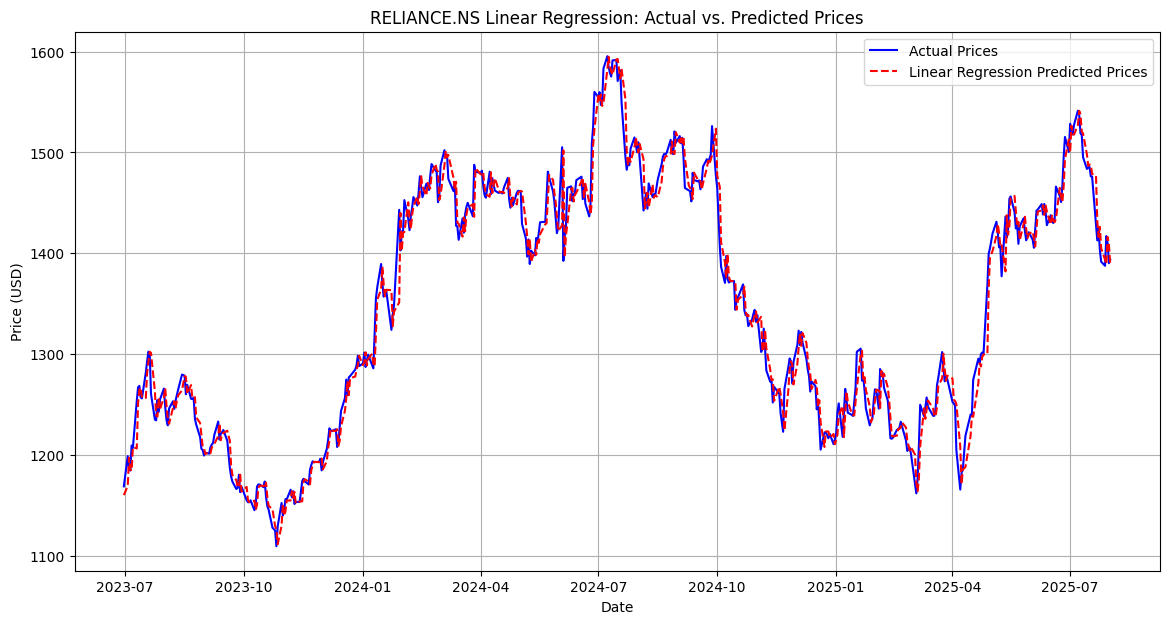

In [7]:
# --- 7. Model Evaluation (Linear Regression) ---
print("--- 7. Model Evaluation (Linear Regression) ---")

lr_mse = mean_squared_error(y_test_lr, lr_predictions)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test_lr, lr_predictions)
lr_r2 = r2_score(y_test_lr, lr_predictions)

print(f"Linear Regression Metrics:")
print(f"  Mean Squared Error (MSE): {lr_mse:.2f}")
print(f"  Root Mean Squared Error (RMSE): {lr_rmse:.2f}")
print(f"  Mean Absolute Error (MAE): {lr_mae:.2f}")
print(f"  R-squared (R²): {lr_r2:.2f}\n")

# Visualization of Linear Regression Predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_lr.index, y_test_lr, label='Actual Prices', color='blue')
plt.plot(y_test_lr.index, lr_predictions, label='Linear Regression Predicted Prices', color='red', linestyle='--')
plt.title(f'{STOCK_TICKER} Linear Regression: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
print("\n")

In [8]:
# --- 8. Model Building and Training (LSTM - Deep Learning) ---
# LSTM is more complex and requires specific data preparation.
print("--- 8. Model Building and Training (LSTM - Deep Learning) ---")

# Use only 'Close' price for LSTM for this simplified example.
# For more advanced LSTM, you would include all relevant features.
lstm_data = df[['Close']].values

# Scale the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(lstm_data)

# Create training data for LSTM
# X will be the past PREDICTION_DAYS closing prices, y will be the next day's closing price
X_lstm = []
y_lstm = []

for i in range(PREDICTION_DAYS, len(scaled_data)):
    X_lstm.append(scaled_data[i-PREDICTION_DAYS:i, 0])
    y_lstm.append(scaled_data[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Reshape data for LSTM (samples, timesteps, features)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

# Split data into training and testing sets (chronological)
train_size_lstm = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size_lstm], X_lstm[train_size_lstm:]
y_train_lstm, y_test_lstm = y_lstm[:train_size_lstm], y_lstm[train_size_lstm:]

print(f"LSTM Training data size: {len(X_train_lstm)}")
print(f"LSTM Testing data size: {len(X_test_lstm)}\n")

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=25))
lstm_model.add(Dense(units=1)) # Output layer for predicting one value (closing price)

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

print("Training LSTM model (this might take a few minutes)...")
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=25, batch_size=32, verbose=1)
print("LSTM Model Training Complete.\n")

--- 8. Model Building and Training (LSTM - Deep Learning) ---
LSTM Training data size: 2043
LSTM Testing data size: 511

Training LSTM model (this might take a few minutes)...
Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0566
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0018
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0017
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0015
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0014
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0013
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0016
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0012
Epoch 9/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0012
Epoch 10/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 9.9282e-04
Epoch 11/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0010
Epoch 12/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 9.9499e-04
Epoch 13/25
64/64 ━━━

--- 9. Model Evaluation (LSTM) ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
LSTM Metrics:
  Mean Squared Error (MSE): 1496.77
  Root Mean Squared Error (RMSE): 38.69
  Mean Absolute Error (MAE): 31.29
  R-squared (R²): 0.90



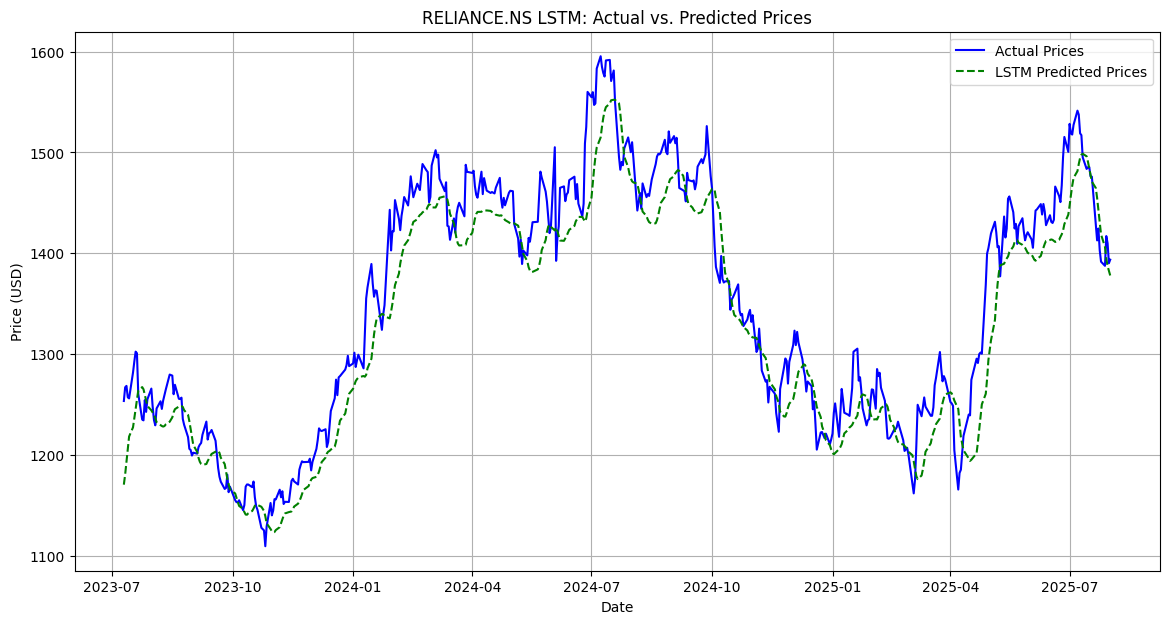

In [9]:
# --- 9. Model Evaluation (LSTM) ---
print("--- 9. Model Evaluation (LSTM) ---")

# Make predictions
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)
# Inverse transform the predictions to original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Inverse transform the actual values for comparison
y_test_lstm_actual = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

lstm_mse = mean_squared_error(y_test_lstm_actual, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_lstm_actual, lstm_predictions)
# Note: R-squared for LSTM is less common but can be calculated
lstm_r2 = r2_score(y_test_lstm_actual, lstm_predictions)

print(f"LSTM Metrics:")
print(f"  Mean Squared Error (MSE): {lstm_mse:.2f}")
print(f"  Root Mean Squared Error (RMSE): {lstm_rmse:.2f}")
print(f"  Mean Absolute Error (MAE): {lstm_mae:.2f}")
print(f"  R-squared (R²): {lstm_r2:.2f}\n")

# Visualization of LSTM Predictions
# Get the dates for the test set
test_dates_lstm = df.iloc[len(df) - len(y_test_lstm_actual):].index

plt.figure(figsize=(14, 7))
plt.plot(test_dates_lstm, y_test_lstm_actual, label='Actual Prices', color='blue')
plt.plot(test_dates_lstm, lstm_predictions, label='LSTM Predicted Prices', color='green', linestyle='--')
plt.title(f'{STOCK_TICKER} LSTM: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
print("\n")

--- 10. Future Price Prediction (LSTM - Example) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/st

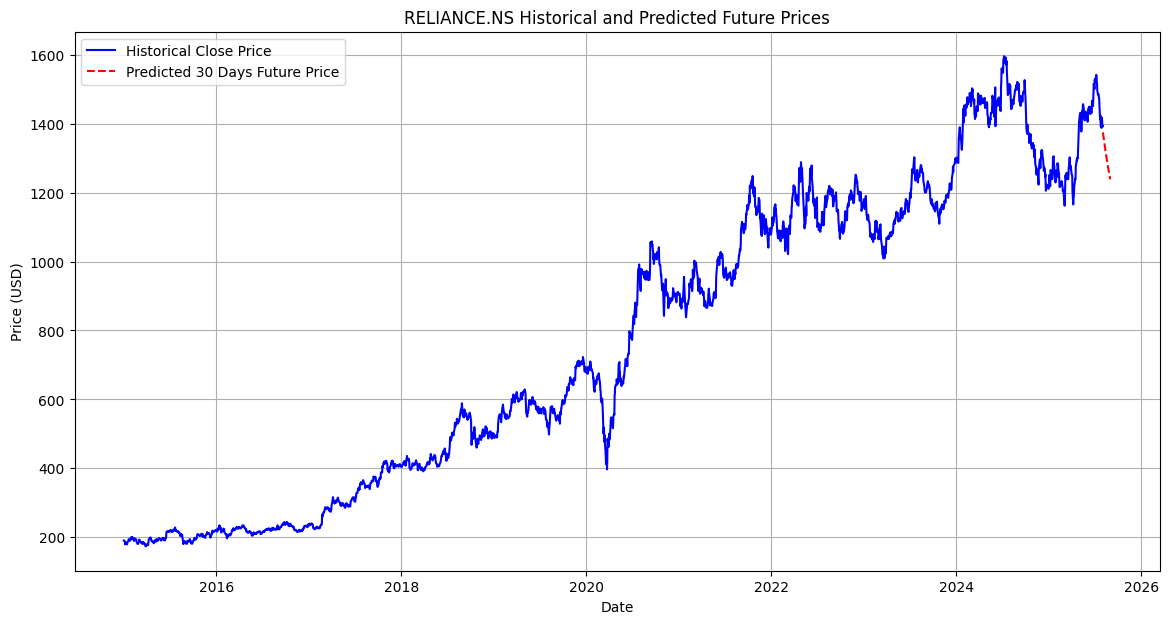


Predicted 30 days future prices for RELIANCE.NS:
            Predicted_Close
2025-08-02      1374.384888
2025-08-03      1369.926514
2025-08-04      1364.999878
2025-08-05      1359.816040
2025-08-06      1354.512451
...
            Predicted_Close
2025-08-27      1254.653687
2025-08-28      1250.533936
2025-08-29      1246.462524
2025-08-30      1242.438843
2025-08-31      1238.461792

--- Project Complete ---


In [10]:
# --- 10. Future Price Prediction (LSTM - Example) ---
print("--- 10. Future Price Prediction (LSTM - Example) ---")

# Get the last PREDICTION_DAYS closing prices from the original scaled data
last_PREDICTION_DAYS = scaled_data[len(scaled_data) - PREDICTION_DAYS:].reshape(1, PREDICTION_DAYS, 1)

future_predictions_scaled = []
current_input = last_PREDICTION_DAYS

for i in range(FUTURE_PRED_DAYS):
    # Predict the next day
    next_day_pred = lstm_model.predict(current_input)[0, 0]
    future_predictions_scaled.append(next_day_pred)

    # Update current_input: remove the oldest value, add the new prediction
    current_input = np.append(current_input[:, 1:, :], [[[next_day_pred]]], axis=1)

# Inverse transform the future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Generate future dates
last_date = df.index[-1]
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, FUTURE_PRED_DAYS + 1)]

# Combine historical data with future predictions for plotting
plot_df = df[['Close']].copy()
future_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Predicted_Close'])

plt.figure(figsize=(14, 7))
plt.plot(plot_df.index, plot_df['Close'], label='Historical Close Price', color='blue')
plt.plot(future_df.index, future_df['Predicted_Close'], label=f'Predicted {FUTURE_PRED_DAYS} Days Future Price', color='red', linestyle='--')
plt.title(f'{STOCK_TICKER} Historical and Predicted Future Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nPredicted {FUTURE_PRED_DAYS} days future prices for {STOCK_TICKER}:")
print(future_df.head())
print("...")
print(future_df.tail())
print("\n--- Project Complete ---")